# Sign Language Recognition Based on AI
## Group Members 
Mohamed Ragab, Hassn Elfait, Diaa Elshater, Saeed

### <div style="text-align: justify"> Sign language is the primary mode of communication for people who are deaf and dumb. Automatic interpretation of sign language into natural language (English) words helps to bridge the communication gap between such people and the real world. Our motivation is to build a model an AI based model that help the deaf people to seamlessly interact in in their deaily life </div>
<br>

In [1]:
# import
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
import time 
import os    
import copy
import math
import csv
from threading import Thread

import torch
import string
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import requests
from bs4 import BeautifulSoup
import re
import urllib3
from urllib.request import urlopen

from IPython.display import clear_output 
from IPython.core.display import Image


from Analysis_Utils import *
from CNN_Utils import *
from DataGen_Utils import *

from global_defs import *

import warnings
warnings.filterwarnings('ignore')


## Models
<div style="text-align: justify"> In this project, there are 5 models proposed to obtain the goal. Those are basic CNN, CNN + LSTM, CNN + Sequence-to-sequence model, end-to-end convolutional LSTM (CLSTM), and CLSTM + Sequence-to-sequence model. The following passages provides detailed explanation of each of those network structure.</div>

### Model 1: Basic CNN

<div style="text-align: justify"> In this project, the designed CNN consist of a 5 layer network structure where there are 3 convolutional layers and 2 fully connected layers. The input dimension is defined in the first layer. That is, the dimension of a 28-by-28 pixel image. The intermediate convolutional layers are interspersed by ReLU and max-pooling layers. A rectangular grid connection is employed in convolutional layer where each connection share the same weights. A ReLU activation function is also installed between 2 fully connected layers. The outputs of convolutional layer are sub-sampled by the 2-by-2 max-pooling layer to reduce its dimension to 64-by-4-by-4 matrix. After that, it is converted to a 1024-by-1 vector and the first fully connected layer maps that vector to 128-by-1 vector. Finally, the last fully connected layer functions to classify 26 alphabets by mapping the 128-by-1 vector to 26-by-1 vector. The network architecture can be seen in the following figure and the class definition of CNN is outlined in the following cell. This architecture is adapted from <a href="https://www.kaggle.com/ranjeetjain3/deep-learning-using-sign-langugage">kaggle</a>.</div>
<img src="CNN_Solo.JPEG" alt="Drawing" style="width: 700px;"/>

#### Class Definition 

In [5]:
class convnet(nn.Module):

    def __init__(self, classes, dropout1):

        super(convnet, self).__init__()
        
        # CL1:   28 x 28  -->    64 x 28 x 28 
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        
        # MP1: 64 x 28 x 28 -->    64 x 14 x 14
        self.pool1  = nn.MaxPool2d(2,2)
        
        # CL2:   64 x 14 x 14  -->    64 x 14 x 14 
        self.conv2 = nn.Conv2d(64,  64,  kernel_size=3, padding=1 )
        
        # MP2: 64 x 14 x 14  -->    64 x 7 x 7
        self.pool2 = nn.MaxPool2d(2,2)
        
        # CL3:   64 x 7 x 7  -->    64 x 7 x 7 
        self.conv3 = nn.Conv2d(64,  64,  kernel_size=3, padding=1 )
        
        self.to_pad = 1
        # MP3: 64 x 7 x 7  -->    64 x 4 x 4 or 64 x 3 x 3, depending on padding
        self.pool3 = nn.MaxPool2d(2,2, padding=self.to_pad)
        
        if self.to_pad:
            # LL1:   64 x 4 x 4 = 1024 -->  128 
            self.linear1 = nn.Linear(1024, 128)
        else:
            # LL1:   64 x 3 x 3 = 576 -->  128 
            self.linear1 = nn.Linear(576, 128)
        
        self.dropout1 = nn.Dropout(dropout1) 
        
        # LL2:   128  -->  classes
        self.linear2 = nn.Linear(128, classes)


    def forward(self, x):

        # CL1:   28 x 28  -->    64 x 28 x 28 
        x = self.conv1(x)
        x = F.relu(x)
        
        # MP1: 64 x 28 x 28 -->    64 x 14 x 14
        x = self.pool1(x)
        
        # CL2:   64 x 14 x 14  -->    64 x 14 x 14 
        x = self.conv2(x)
        x = F.relu(x)
        
        # MP2: 64 x 14 x 14  -->    64 x 7 x 7
        x = self.pool2(x)

        # CL3:   64 x 7 x 7  -->    64 x 7 x 7 
        x = self.conv3(x)
        x = F.relu(x)
        
        # MP3: 64 x 7 x 7  -->    64 x 4 x 4 or 64 x 3 x 3, depending on padding
        x = self.pool3(x)
        
        
        # LL1 
        if self.to_pad: x = x.view(-1, 1024)   ### reshape
        else: x = x.view(-1, 576)
        x = self.linear1(x)
        x = F.relu(x)
        
        
        # Droput
        x = self.dropout1(x)
        
        # LL2:   128  -->  classes
        x = self.linear2(x)
    
        return x


#### Class Definition 

In [6]:
class Recurrent_Layer(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super(Recurrent_Layer, self).__init__()
        self.dropout = nn.Dropout(0.02) # this can be removed while without dropout configuration
        self.layer1 = nn.Embedding (vocab_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, bidirectional=True)
        self.fc = nn.Linear(2*hidden_size, vocab_size) # if bidirectional=True then hidden size multiplied by 2

    def forward(self, x, h_init,c_init):
        x = self.dropout(x) # this can be removed while without dropout configuration
        g_seq = self.layer1(x)
        h_seq, (h_final, c_final) = self.lstm(g_seq, (h_init,c_init))
        score_seq = self.fc(h_seq)
        
        return score_seq,  h_final , c_final

### Model 2: CNN + Squence-to-sequence Model
The **squence-to-sequence** network is employed in this project. In this sequence to sequence network, we have two main LSTM networks, one of them is the **encoder** take the missplled outputs of CNN baseleine and try to encode the context of the whole word into one hidden vector with a fixed size and pass to the other part. The other part is the **decoder** which take this context vector and as its initial hidden state coupled with an intial input like "SOW" to predict the next character of the word. The detailed working process is as follows, first we try get the vector representation for every character by employing a learnabel **character embedding** layer, which in turn forwoard the vector representation of every character to the lstm cells.Each cell in LSTM layer will take the hidden state from the prevoius lstm cell coupled with the current input to produce the output, until we reach the last hidden state which have the context of the whole input word, this can be considered as encoding part. After that the decoder part will cosider the encoder's last hidden state as its inital hidden and try to decode this to genertate the correctly spelled words as shown in figure below.
<img src="seq2seq.jpeg" alt="Drawing" style="width: 800px;"/>

#### Class Definition 

In [7]:
# Encoder Architecture 
class EncoderLSTM(nn.Module):
    def __init__(self,input_size, hidden_size):
        super(EncoderLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.embedding=nn.Embedding(input_size, hidden_size)
#         self.dropout=nn.Dropout(0.5)
        self.lstm=nn.LSTM(hidden_size, hidden_size )
    
    def forward(self, x, h_init, c_init):
        
        g_seq=self.embedding(x)
#         g_seq= self.dropout(g_seq)
        output, (h_final,c_final)=self.lstm(g_seq, (h_init, c_init))
        return output, h_final, c_final

In [8]:
# Decoder Architecture 
class DecoderLSTM(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.lstm=nn.LSTM(hidden_size, hidden_size)
        self.out=nn.Linear(hidden_size, output_size)

    def forward(self, x, h_init, c_init):
        output=self.embedding(x)
        output, (h_final, c_final)=self.lstm(output, (h_init, c_init))
        output=self.out(output) # do we need output[0] ?
        #output= self.softmax(output)
        return output, h_final, c_final

### Model 3: End-to-End Convolutional LSTM (CLSTM)
<div style="text-align: justify"> In the realm of deep learning, a reasonable end-to-end model and sufficient data for training helps the user to get closer to the problem solution. It also worth mentioning that the word prediction problem satisfies the data requirement because it is easy to generate a lot of words. Because of this reason, this project realizes end-to-end convolutional LSTM (CLSTM) to predict the word from a sequence of images. CNN should be able to handle the spatio dynamic while the temporal dynamic is circumvented by LSTM. Unlike our previous models, where the network parameters are optimized based on different objective function, CLSTM parameters are adjusted using loss from top layer. The following figure depicts the CLSTM network structure.</div>
<img src="clstm.jpeg" alt="Drawing" style="width: 700px;"/>

#### Class Definition 

In [9]:
class CLSTM(nn.Module):
    
    def _init_(self, h_dim, classes, bi_dir=False):
        
        super(CLSTM, self)._init_()

        self.hidden_dim = h_dim
        
        # CL1:   28 x 28  -->    64 x 28 x 28 
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        
        # MP1: 64 x 28 x 28 -->    64 x 14 x 14
        self.pool1  = nn.MaxPool2d(2,2)
        
        # CL2:   64 x 14 x 14  -->    64 x 14 x 14 
        self.conv2 = nn.Conv2d(64,  64,  kernel_size=3, padding=1 )
        
        # MP2: 64 x 14 x 14  -->    64 x 7 x 7
        self.pool2 = nn.MaxPool2d(2,2)
        
        # CL3:   64 x 7 x 7  -->    64 x 7 x 7 
        self.conv3 = nn.Conv2d(64,  64,  kernel_size=3, padding=1 )
        
        self.to_pad = 0
        # MP3: 64 x 7 x 7  -->    64 x 4 x 4 or 64 x 3 x 3, depending on padding
        self.pool3 = nn.MaxPool2d(2,2, padding=self.to_pad)
        
        if self.to_pad:
            # LL1:   64 x 4 x 4 = 1024 -->  128 
            self.linear1 = nn.Linear(1024, 128)
        else:
            # LL1:   64 x 3 x 3 = 576 -->  128 
            self.linear1 = nn.Linear(576, 128)
        
        
        self.dropout1 = nn.Dropout(0.7)
        
        self.dropout2 = nn.Dropout(0.7)
        
        # LSTM
        self.lstm_in_dim = 128
        self.lstm = nn.LSTM(self.lstm_in_dim, self.hidden_dim, bidirectional=bi_dir)

        # linear
        self.hidden2label1 = nn.Linear( self.hidden_dim*(1+int(bi_dir)), classes )
        
        

    def forward(self, x, h_init, c_init):
        
        x = self.conv1(x)
        x = F.relu(x)

        x = self.pool1(x)
         
        x = self.conv2(x)
        x = F.relu(x)
        
        x = self.pool2(x)
 
        x = self.conv3(x)
        x = F.relu(x)
        
        # MP3: 64 x 7 x 7  -->    64 x 4 x 4 or 64 x 3 x 3, depending on padding
        x = self.pool3(x)
        
        if self.to_pad: x = x.view(-1, 1024)   ### reshape
        else: x = x.view(-1, 576)
        x = self.linear1(x)
        x = F.relu(x)     
        
        # Droput
        x = self.dropout1(x)

        cnn_x = F.relu(x) 
        
        # LSTM
        g_seq = cnn_x.unsqueeze(dim=1)
        lstm_out, (h_final, c_final) = self.lstm(g_seq, (h_init, c_init))
        
        # Droput
        lstm_out = self.dropout2(lstm_out)
        
        # linear
        cnn_lstm_out = self.hidden2label1(lstm_out)  ###activtions are implicit

        # output
        scores = cnn_lstm_out

        return scores, h_final, c_final

## Training Procedures for Different Models

### Training of CNN

<div style="text-align: justify"> The baseline CNN is trained on the Sign Language images. Since each image corresponds to a single alphabet label, the loss calculated here is at the alphabet (or character) level. This is different from the word-level loss used in other parts of the report. Since the baseline CNN is non-recurrent, it needs to be trained on alphabet-level loss. 
Same applies to percentage error, which is the total percentage of images recognized as Wrong alphabets. </div>

In [11]:
model_name = 'Cnet_Kaggle'

#### Hyperparameters
We observed the fastest rate of training convergence for this network with learning rate of 0.001. This value is divided by 1.5 after every 10th epoch of training. 

In [12]:
my_lr = 0.001 
epochs = 50
batch_size = 128         
CNNutils = CNN_Utils(my_lr, batch_size, epochs)

#### Cross Validation (CV)

The check the performance of the network on samples from training set, the data is randomly split into 90% training and 10% 
validation portions in 10 iterations of CV.

The record of performance is shown below.

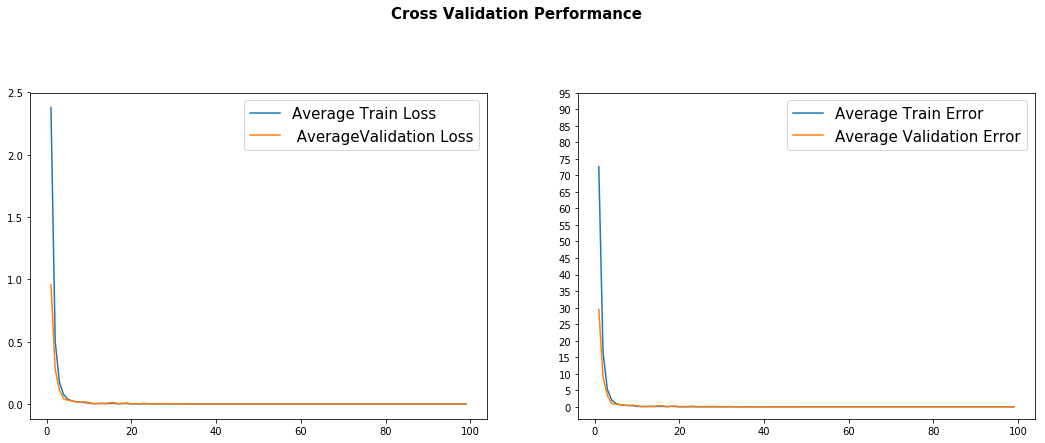

In [13]:
hCV = torch.load(model_name + '_CV_history.pt')
train_history_over_CV = hCV['train_history']
val_history_over_CV = hCV['test_history']
CNNutils.plot_CV_history(copy.deepcopy(train_history_over_CV), copy.deepcopy(val_history_over_CV))

The model seems to be performing quite well, given the low average validation error. However, this may also mean that 
the entire training data comes from a very closely distributed population. There is no guarantee of test data coming from same distribution, as we will see in the next section.

#### Full Training

Here, we train the CNN on entire training dataset while simultaneuosly evaluating on the actual test data. 

The record of performance is shown below.

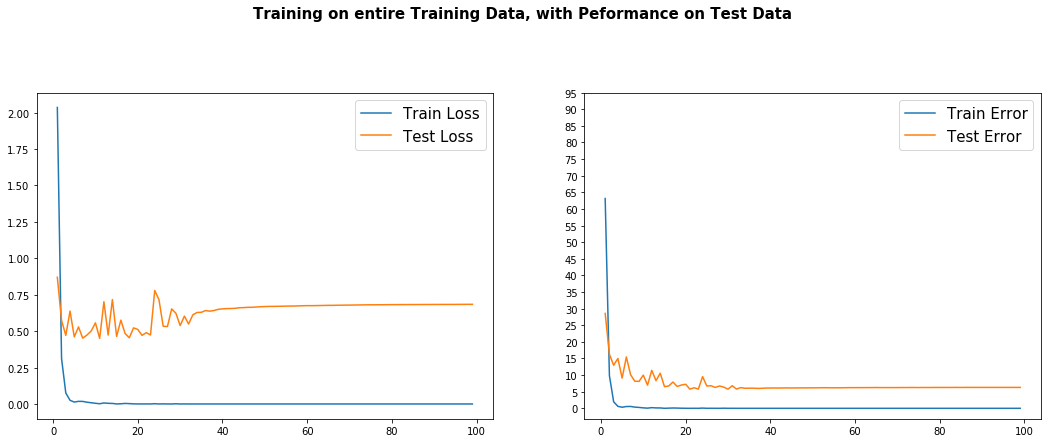

In [14]:
hFull = torch.load(model_name + '_full_history.pt')
train_history = hFull['train_history']
test_history = hFull['test_history']
CNNutils.plot_FullTrain_history(train_history, test_history)

The test performance of CNN is worse than that on Cross-Validation data. Hence, it can be inferred that test images have been sampled from a population outside the training set.

### Training of LSTM
<div style="text-align: justify"> The training process of LSTM is started by using simple LSTM model, that is unidirectional LSTM. The learning rate is set to be decaying, that is started by 0.05 and is divided by 1.1 every 10 epoch. After 204 epoch, it only achieves 5% testing accuracy and 85% training accuracy. This is because to observe the misspelled word it is requred the whole context of the word. Unidirectional LSTM, however, cannot observe the whole context as it observes a word from one direction. Because of this reason, bidirectional LSTM is utilized to improve the result. By applying the same setting, it is capable of delivering almost 84% in around 200 epoch while the training error is almost 100%. From this result, it can be observed that the network is overfitting. It can be avoided by adding dropout in the training phase. The ammount of dropout is 0.2. The result is that the testing accuracy increases up to 90% while the training accuracy is 99%. Referring to the plot of loss below, it is decided to stop the training phase because there is no significant decrease in loss. All the results are reported in the following table. After that, this model is stacked to the output of CNN layer. </div>

| Model | Train Accuracy | Test Accuracy | Train Loss | Test Loss |
| --- | --- | --- | --- | --- |
| Unidirectional LSTM | 85.29% | 5.07% | 0.067 | 0.985 |
| Bidirectional LSTM | 99.56% | 83.98% | 0.002 | 0.12 |
| Bidirectional LSTM with dropout | 99.12% | 90% | 0.0045 | 0.07 |

In [22]:
# parameter of bidirectional LSTM with dropout
hidden_size=256
vocab_size =26
my_lr=0.05

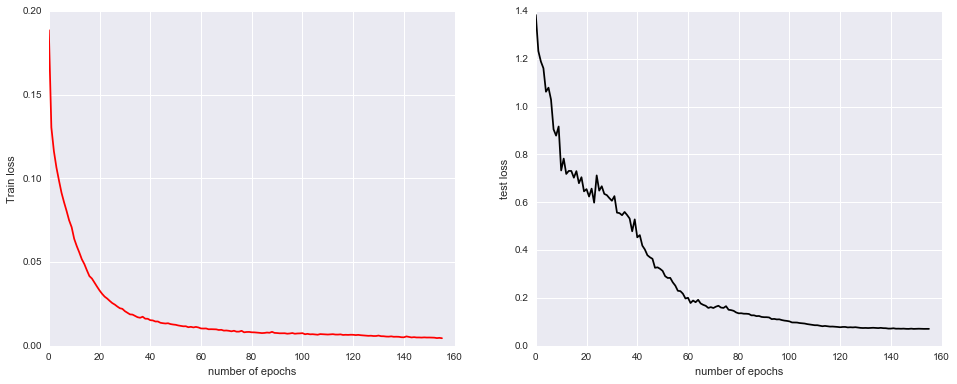

In [22]:
import torch
all_parameters= torch.load("lstm_single_char_50_mutation_bid_drop_02 (1).pt", map_location='cpu')
from seq2seq_utils import plot_loss
from seq2seq_utils import pie_plot_lstm

plot_loss(all_parameters)

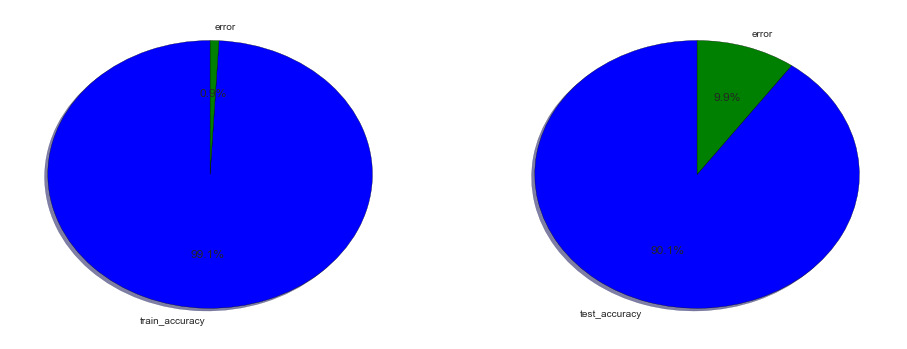

In [23]:
pie_plot_lstm(all_parameters)

Training and testing accuracy of bidirectional LSTM with dropout.
## Training of Sequence-to-sequence Model

#### Training Procedure  


In order to train our model we started by passing the input character to the embedding layer which in turn pass it to LSTM layer, which in turn wil encoder the whole input word in the last hidden state and send it to the decoder. Decoder training has two diffrent phases one phase is by forcing the input of the decoder to be to the target labels, instead of the decoder gussing as shown in figure(2). This is called **Teacher Forcing** which help in increasing the convergence speed, however it exhibit some instabliblity. So, we will  randomly use teacher forcing by some ratio  in order to improve the converegence and keep stablitiy.The two phases are shown the folllowing figures.

<img src="TeacherForcing.jpeg" alt="Drawing" style="width: 700px;"/>

In order to tune our **hyberparameterts** we started to train our  model on small subset of the data, and try to overfit this small subset of data, at this point we ensured that we have enough capacity. In our case, we tried this and ended with these parameters,  **256 hidden size** of the lstm cell, we also used **Stochastic Gradient Descent(SGD)** which is the optimal for lstm and reached to optimal, we also we ended up with a good **learning rate strategy** which start by learning rate=**0.04** and reduce it by **1.1** every **10** epochs.With this strategyy it took us 72 epochs to end up with training accuracy of **99%** and testing accuracy **96.1%**.


In [21]:
# hyperarameters
hidden_size=256
vocab_size=26    
my_lr=0.04
Teacher_forcing_ratio=0.4

We start to train our model using theses arameters and here is a summary of accuracy and losses for both training and testing.


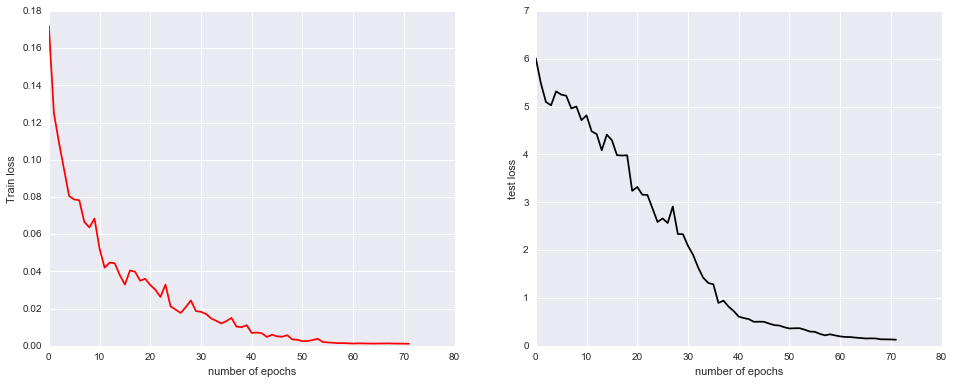

In [25]:
import torch
all_parameters= torch.load("seq_seq_model_sinlgle_char_50_mutation_200.pt", map_location='cpu')
from seq2seq_utils import plot_loss
from seq2seq_utils import pie_plot_lstm

plot_loss(all_parameters)

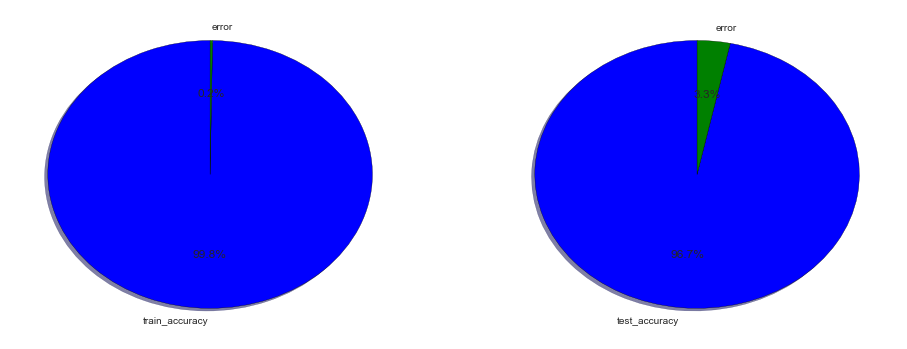

In [26]:
pie_plot_lstm(all_parameters)

Let's check various sequences for the first word

## Accuracy
This measure is based on word-level prediction accuracy. If the predicted word matches the target word, it is treated as 1 positive instance of prediction. If the predicted word does not match target word by one or more alphabets, it is treated as 1 instance of negative prediction. In the plots below, we show the percentages of correct and incorrect predictions for various models.

## Conclusions
<div style="text-align: justify"> This project presents a combination of CNN, Lsequence-to-sequence model to solve word prediction problem from a sequence of images. There are 3 models examined, basic CNN, CNN + sequence-to-sequence model,and CLSTM. The hand gesture images dataset is exploited to train the basic CNN. A code is created to generate the sequence of images dataset which represents a unique word. In order to train the LSTM, frequent misspelled word is crawled from wikipedia. A further point, some mutation of misspelled word also generated to increase the number of data. Our numerical study shows that our model delivers the most encouraging numerical result from other  benchmarked algorithms. <div>